# Imports and define expectation func

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [4]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.Utils.plotting_utils import plot_distributions, plot_distributions, plot_samples, plot_sampling_info, \
    plot_divergences, plot_history
from FittedModels.train import LearntDistributionManager
from Utils.plotting_utils import plot_func2D, plot_distribution, plot_samples_single_dist
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
from FittedModels.Models.FlowModel import FlowModel
import matplotlib.pyplot as plt
from TargetDistributions.MoG import MoG
from TargetDistributions.MoG import custom_MoG
torch.set_default_dtype(torch.float64)

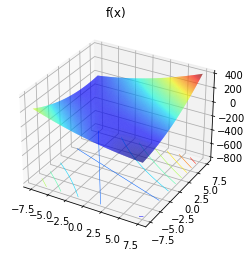

In [5]:
expectation_func_fig = plot_func2D(expectation_function, n_points=200, range=15)

# Lumpy High Dimension Flow Target Distribution

In [6]:
torch.manual_seed(0) 
dim = 4
scaling_factor = 4.0
lr = 1e-4
weight_decay=1e-6
n_flow_steps=40
n_samples_estimation = int(1e6)
epochs = int(1e4)
batch_size = int(1e3)
train_prior=True

In [7]:
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=3).to("cuda")
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
print(true_expectation)
print(MC_estimate_true_expectation(target, expectation_function, int(1e6))) # print twice to make sure estimates are resonably close

tensor(48.8308, device='cuda:0')
tensor(48.8308, device='cuda:0')


# DReG, alpha=2

In [12]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=n_flow_steps, scaling_factor=scaling_factor, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=lr, 
                                  weight_decay=weight_decay)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

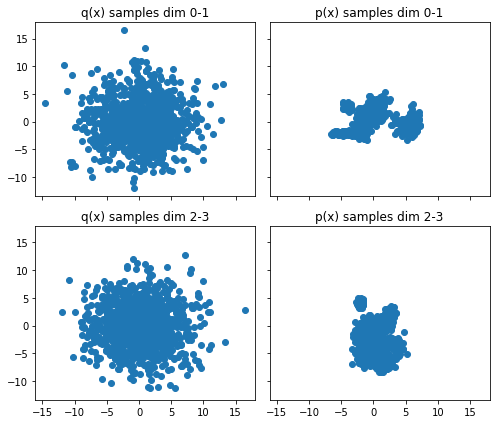

In [13]:
samples_fig_before = plot_samples(tester) # this just looks at 2 dimensions

### If we want to train the prior first

loss: 0.7051326314365425, mean log p_x -43.455774569445865: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]  


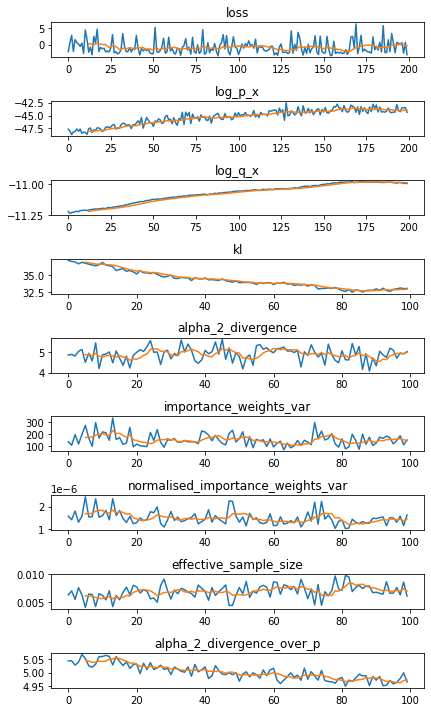

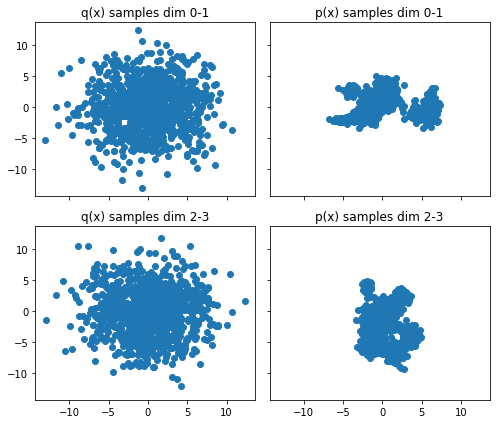

In [14]:
if train_prior:
    history_prior = tester.train_prior(epochs=200, batch_size=batch_size, lr=0.01)
    plot_history(history_prior)
    plot_samples(tester)
    expectation_prior_trained, info_prior = tester.estimate_expectation(n_samples_estimation, expectation_function)

### proper training

loss: -1.9591735373714374, mean log p_x -43.88061607986966:   0%|          | 0/10000 [00:00<?, ?it/s]

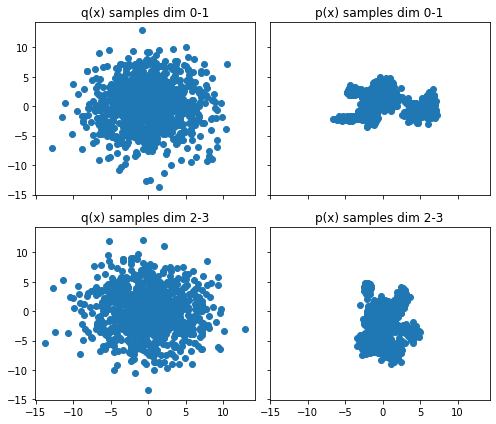

loss: -0.7818817439227836, mean log p_x -43.0733734099203:  10%|█         | 1000/10000 [03:59<34:06,  4.40it/s]  

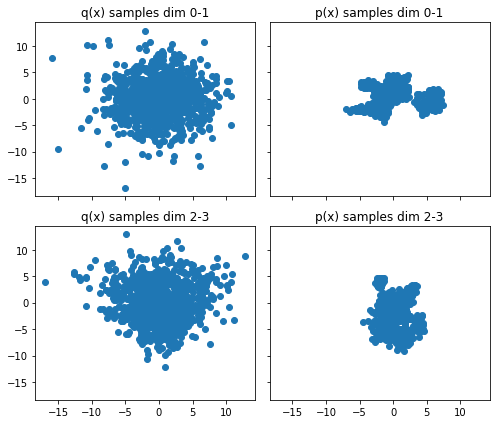

loss: -2.442351871364441, mean log p_x -41.88358013788694:  20%|██        | 2000/10000 [07:34<25:38,  5.20it/s]  

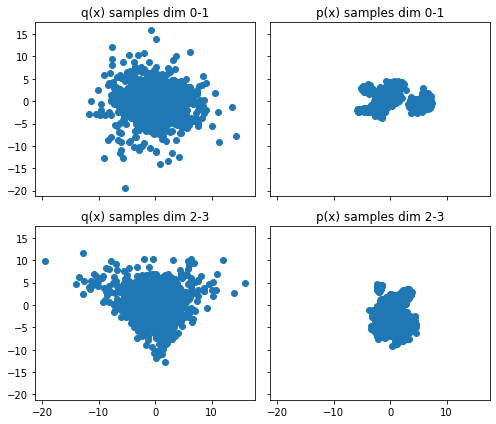

loss: -2.6956983716448764, mean log p_x -41.155227716536395:  30%|███       | 3000/10000 [10:53<23:38,  4.93it/s]

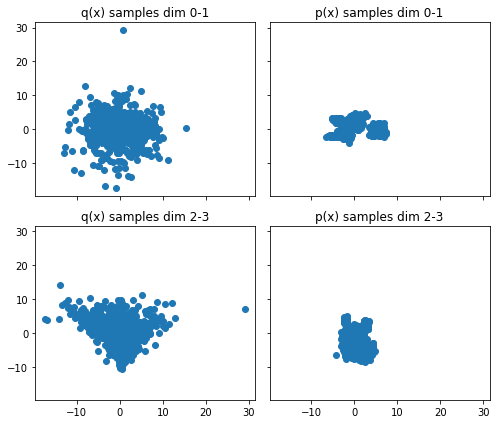

loss: -2.9368867036320676, mean log p_x -39.90292493257788:  40%|████      | 4000/10000 [14:29<23:57,  4.17it/s] 

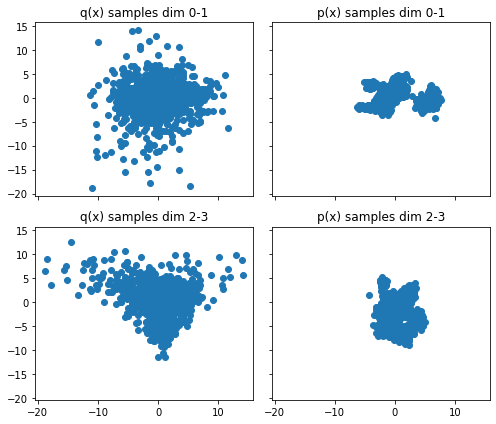

loss: -1.6038674677065152, mean log p_x -38.6639361834688:  50%|█████     | 5000/10000 [18:30<19:21,  4.30it/s]   

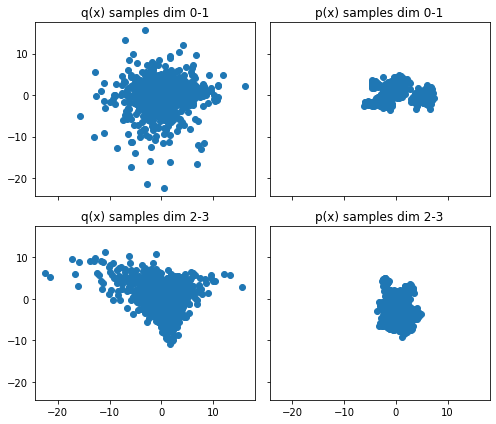

loss: -3.18206366945419, mean log p_x -38.439956408769596:  60%|██████    | 6000/10000 [22:33<16:14,  4.10it/s]  

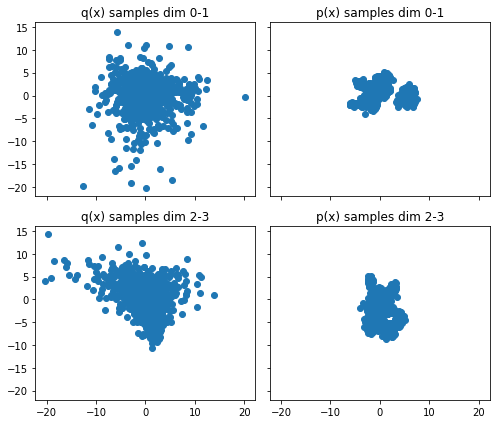

loss: -2.478417179850942, mean log p_x -39.03948150326569:  70%|███████   | 7000/10000 [26:48<15:16,  3.27it/s]  

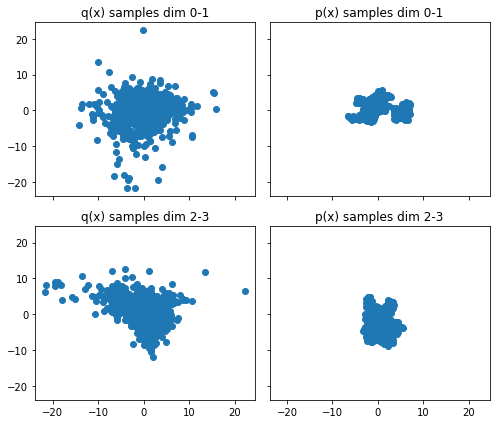

loss: -2.1156297490696714, mean log p_x -37.785928166121465:  80%|████████  | 8000/10000 [31:52<07:37,  4.38it/s]

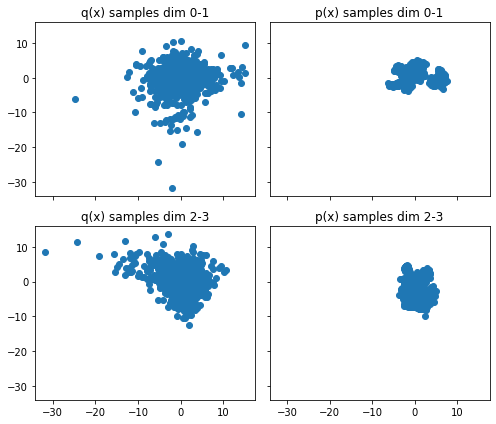

loss: -2.4978032199900664, mean log p_x -39.05920134841337:  90%|█████████ | 9000/10000 [35:45<03:14,  5.14it/s] 

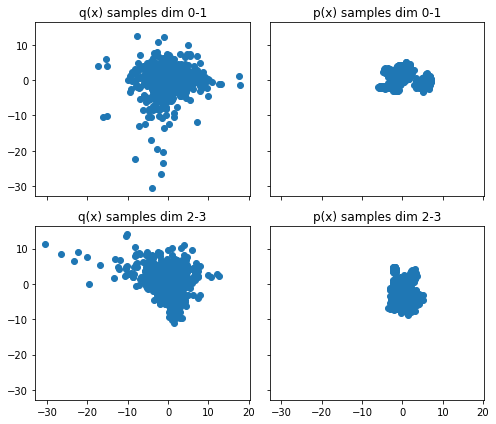

loss: 2.079805742641219, mean log p_x -37.71026345189032: 100%|██████████| 10000/10000 [38:54<00:00,  4.28it/s]  


In [16]:
history = tester.train(epochs, batch_size=batch_size, intermediate_plots=True) #clip_grad_norm=True, max_grad_norm=1)

In [17]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n"
      f"effective sample size before is {info_before['effective_sample_size'] / n_samples_estimation}\n"
      f"effective sample size after train is {info['effective_sample_size'] / n_samples_estimation}\n"
      f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

if train_prior:
    print(f"estimate after prior training is {expectation_prior_trained} \n"
        f"effective sample size trained prior is {info_prior['effective_sample_size'] / n_samples_estimation}\n")

estimate before training is 48.774132307327854 
estimate after training is 46.551285525764115 
effective sample size before is 0.006383719417763016
effective sample size after train is 0.009434237712515984
variance in weights is 1.049970101497513e-10


NameError: name 'expectation_prior_trained' is not defined

In [ ]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n"
      f"effective sample size before is {info_before['effective_sample_size'] / n_samples_estimation}\n"
      f"effective sample size after train is {info['effective_sample_size'] / n_samples_estimation}\n"
      f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

if train_prior:
    print(f"estimate after prior training is {expectation_prior_trained} \n"
        f"effective sample size trained prior is {info_prior['effective_sample_size'] / n_samples_estimation}\n")

In [ ]:
samples_fig_after = plot_samples(tester)

In [ ]:
plot_divergences(history)

In [ ]:
plot_sampling_info(history)

In [ ]:
plot_history(history)

# KL

In [22]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=n_flow_steps, scaling_factor=scaling_factor, flow_type="RealNVP")
tester_kl = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl", lr=lr, 
                                  weight_decay=1e-6)
expectation_before_kl, info_before_kl = tester.estimate_expectation(n_samples_estimation, expectation_function)

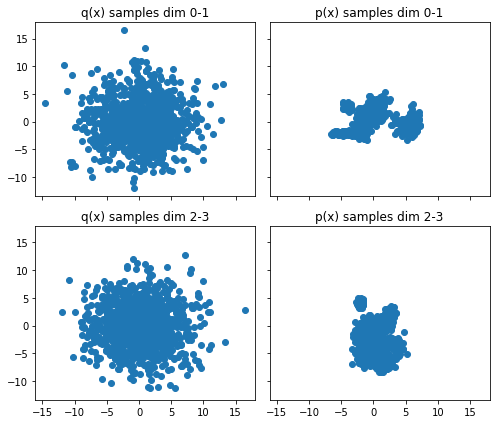

In [23]:
plot_samples(tester_kl)

loss: 36.4020651161874, mean log p_x -47.6235010649162:   0%|          | 0/10000 [00:00<?, ?it/s]

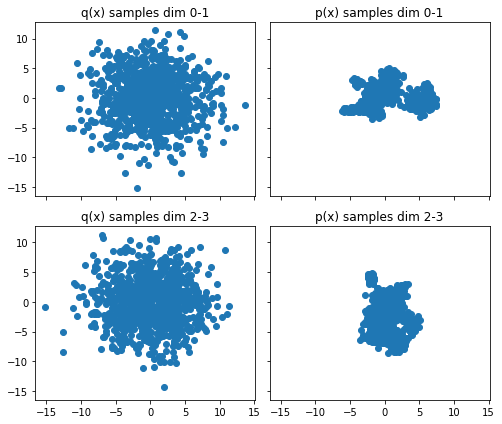

loss: 17.68492612132636, mean log p_x -27.424572448830027:   8%|▊         | 801/10000 [03:14<1:08:07,  2.25it/s] 

Couldn't calculate alpha divergence over p


loss: 16.149077631986454, mean log p_x -25.533250662951033:   9%|▉         | 901/10000 [03:42<1:10:12,  2.16it/s]

Couldn't calculate alpha divergence over p


loss: 15.224152255154507, mean log p_x -24.271073343538454:  10%|█         | 1000/10000 [04:09<42:09,  3.56it/s] 

Couldn't calculate alpha divergence over p


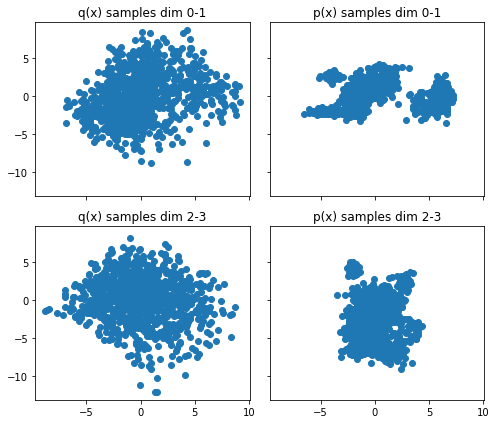

loss: 13.83221499989204, mean log p_x -22.58391084041197:  11%|█         | 1101/10000 [04:38<1:07:49,  2.19it/s]  

Couldn't calculate alpha divergence over p


loss: 13.049863478192199, mean log p_x -21.513920463139556:  12%|█▏        | 1201/10000 [05:06<1:07:59,  2.16it/s]

Couldn't calculate alpha divergence over p


loss: 12.72877098191234, mean log p_x -20.957475296973747:  13%|█▎        | 1301/10000 [05:34<1:09:04,  2.10it/s] 

Couldn't calculate alpha divergence over p


loss: 11.566825715743235, mean log p_x -19.481704960858746:  14%|█▍        | 1401/10000 [06:02<1:03:38,  2.25it/s]

Couldn't calculate alpha divergence over p


loss: 10.827112235227968, mean log p_x -18.47881579087545:  15%|█▌        | 1501/10000 [06:30<1:03:00,  2.25it/s] 

Couldn't calculate alpha divergence over p


loss: 10.904877880805877, mean log p_x -18.109827658414886:  16%|█▌        | 1601/10000 [06:58<1:04:25,  2.17it/s]

Couldn't calculate alpha divergence over p


loss: 10.980683581117924, mean log p_x -17.928223596812163:  17%|█▋        | 1701/10000 [07:26<1:07:19,  2.05it/s]

Couldn't calculate alpha divergence over p


loss: 10.42298397656836, mean log p_x -16.888140570503904:  18%|█▊        | 1801/10000 [07:54<1:02:33,  2.18it/s] 

Couldn't calculate alpha divergence over p


loss: 10.949101878215675, mean log p_x -16.8957886800324:  19%|█▉        | 1901/10000 [08:22<1:04:07,  2.10it/s] 

Couldn't calculate alpha divergence over p


loss: 12.417293963384703, mean log p_x -17.411318521934742:  20%|██        | 2000/10000 [08:50<35:28,  3.76it/s]

Couldn't calculate alpha divergence over p


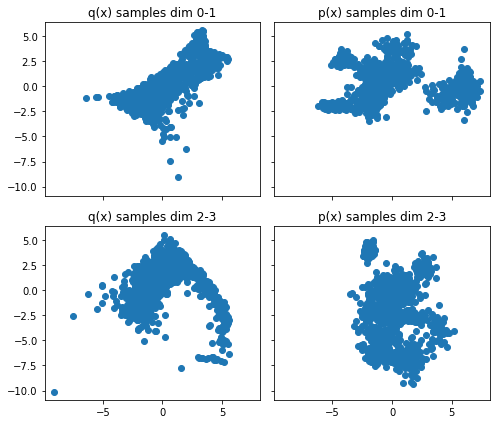

loss: 13.844869258209716, mean log p_x -17.830168250790187:  21%|██        | 2101/10000 [09:19<1:00:23,  2.18it/s]

Couldn't calculate alpha divergence over p


loss: 14.550520357042013, mean log p_x -17.809299331949376:  22%|██▏       | 2201/10000 [09:47<58:36,  2.22it/s]  

Couldn't calculate alpha divergence over p


loss: 15.484849002696352, mean log p_x -17.928854912035348:  23%|██▎       | 2301/10000 [10:15<59:12,  2.17it/s]

Couldn't calculate alpha divergence over p


loss: 15.884782639835674, mean log p_x -17.406292182188828:  24%|██▍       | 2401/10000 [10:43<59:33,  2.13it/s]

Couldn't calculate alpha divergence over p


loss: 16.379014909269863, mean log p_x -17.126423050447624:  25%|██▌       | 2501/10000 [11:11<53:46,  2.32it/s]

Couldn't calculate alpha divergence over p


loss: 16.882902109459025, mean log p_x -16.563496273990452:  26%|██▌       | 2601/10000 [11:39<54:41,  2.25it/s]

Couldn't calculate alpha divergence over p


loss: 17.860940779424425, mean log p_x -16.491515161853147:  27%|██▋       | 2701/10000 [12:07<55:09,  2.21it/s]

Couldn't calculate alpha divergence over p


loss: 18.937258876453214, mean log p_x -16.628134276815537:  28%|██▊       | 2801/10000 [12:35<56:58,  2.11it/s]

Couldn't calculate alpha divergence over p


loss: 20.109394275551214, mean log p_x -16.636304577800125:  29%|██▉       | 2901/10000 [13:03<53:05,  2.23it/s]

Couldn't calculate alpha divergence over p


loss: 20.792812183178917, mean log p_x -16.16936702103294:  30%|███       | 3000/10000 [13:30<25:04,  4.65it/s] 

Couldn't calculate alpha divergence over p


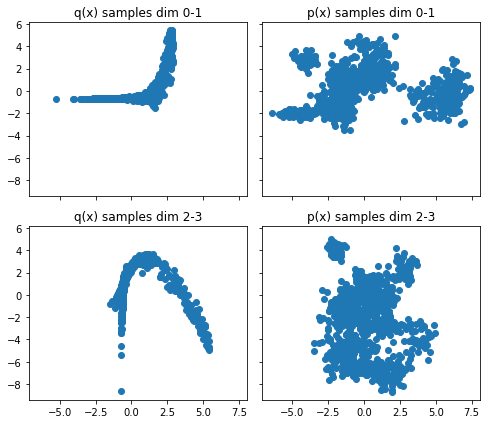

loss: 23.293777068229787, mean log p_x -16.424900086838125:  31%|███       | 3101/10000 [13:59<51:33,  2.23it/s] 

Couldn't calculate alpha divergence over p


loss: 26.805220272683076, mean log p_x -16.27543169940866:  32%|███▏      | 3201/10000 [14:28<50:37,  2.24it/s] 

Couldn't calculate alpha divergence over p


loss: 23.370741776270197, mean log p_x -15.735756734783152:  33%|███▎      | 3301/10000 [14:56<50:59,  2.19it/s]

Couldn't calculate alpha divergence over p


loss: 24.042876397077162, mean log p_x -15.450613980691232:  34%|███▍      | 3401/10000 [15:24<48:47,  2.25it/s]

Couldn't calculate alpha divergence over p


loss: 24.832538048942716, mean log p_x -15.559810008422994:  35%|███▌      | 3501/10000 [15:52<50:27,  2.15it/s]

Couldn't calculate alpha divergence over p


loss: 26.33131021267028, mean log p_x -15.85411327655615:  36%|███▌      | 3601/10000 [16:20<48:53,  2.18it/s]  

Couldn't calculate alpha divergence over p


loss: 26.233740483894977, mean log p_x -15.502048604049426:  37%|███▋      | 3701/10000 [16:48<48:16,  2.17it/s]

Couldn't calculate alpha divergence over p


loss: 26.26273753362467, mean log p_x -15.546838573163445:  38%|███▊      | 3801/10000 [17:17<49:33,  2.08it/s] 

Couldn't calculate alpha divergence over p


loss: 26.894498008806153, mean log p_x -15.695816430831991:  39%|███▉      | 3901/10000 [17:45<46:11,  2.20it/s]

Couldn't calculate alpha divergence over p


loss: 28.694872658772706, mean log p_x -16.38576235236536:  40%|████      | 4000/10000 [18:12<27:04,  3.69it/s] 

Couldn't calculate alpha divergence over p


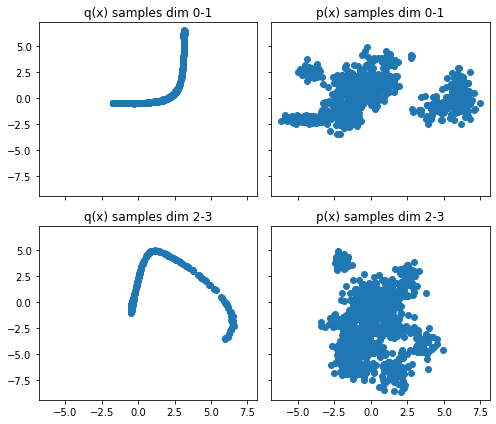

loss: 32.1945497277319, mean log p_x -17.927237940889054:  41%|████      | 4101/10000 [18:42<43:17,  2.27it/s]   

Couldn't calculate alpha divergence over p


loss: 31.840523463373092, mean log p_x -18.24625040696247:  42%|████▏     | 4201/10000 [19:10<44:37,  2.17it/s]

Couldn't calculate alpha divergence over p


loss: 33.60395667562645, mean log p_x -19.315362254645347:  43%|████▎     | 4301/10000 [19:38<41:54,  2.27it/s]

Couldn't calculate alpha divergence over p


loss: 28.877697592913574, mean log p_x -16.807082496862837:  44%|████▍     | 4401/10000 [20:03<29:09,  3.20it/s]

Couldn't calculate alpha divergence over p


loss: 36.19331198425693, mean log p_x -19.64856001646421:  45%|████▌     | 4501/10000 [20:26<41:15,  2.22it/s]  

Couldn't calculate alpha divergence over p


loss: 33.04462854892867, mean log p_x -18.178812931681925:  46%|████▌     | 4601/10000 [20:54<39:43,  2.27it/s]

Couldn't calculate alpha divergence over p


loss: 33.979571194058884, mean log p_x -17.38221896612399:  47%|████▋     | 4701/10000 [21:22<39:01,  2.26it/s]

Couldn't calculate alpha divergence over p


loss: 36.34958617897257, mean log p_x -17.85469092342397:  48%|████▊     | 4801/10000 [21:50<39:57,  2.17it/s] 

Couldn't calculate alpha divergence over p


loss: 37.53341210457, mean log p_x -17.447332639177162:  49%|████▉     | 4901/10000 [22:17<37:33,  2.26it/s]  

Couldn't calculate alpha divergence over p


loss: 38.82258532860353, mean log p_x -16.82426767394872:  50%|█████     | 5000/10000 [22:45<22:31,  3.70it/s]

Couldn't calculate alpha divergence over p


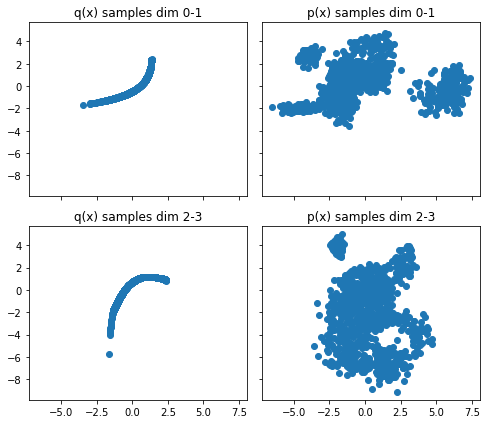

loss: 40.162263060709215, mean log p_x -16.523689660549834:  51%|█████     | 5101/10000 [23:14<36:03,  2.26it/s]

Couldn't calculate alpha divergence over p


loss: 42.276537370051756, mean log p_x -16.40047932509901:  52%|█████▏    | 5201/10000 [23:42<31:22,  2.55it/s] 

Couldn't calculate alpha divergence over p


loss: 44.78074939809292, mean log p_x -16.387687056631126:  53%|█████▎    | 5301/10000 [24:07<34:26,  2.27it/s]

Couldn't calculate alpha divergence over p


loss: 46.33319542645758, mean log p_x -16.0226317840262:  54%|█████▍    | 5401/10000 [24:28<25:02,  3.06it/s]  

Couldn't calculate alpha divergence over p


loss: 48.76260386930358, mean log p_x -15.922124171148456:  55%|█████▌    | 5501/10000 [24:49<24:09,  3.10it/s]

Couldn't calculate alpha divergence over p


loss: 51.05258385221244, mean log p_x -15.681927744620603:  56%|█████▌    | 5601/10000 [25:09<25:11,  2.91it/s]

Couldn't calculate alpha divergence over p


loss: 52.94801625617968, mean log p_x -15.828878379615148:  57%|█████▋    | 5701/10000 [25:30<23:42,  3.02it/s]

Couldn't calculate alpha divergence over p


loss: 54.7829652495881, mean log p_x -16.037359438860232:  58%|█████▊    | 5801/10000 [25:51<22:40,  3.09it/s] 

Couldn't calculate alpha divergence over p


loss: 56.14916670797485, mean log p_x -15.898239423874632:  59%|█████▉    | 5901/10000 [26:12<22:07,  3.09it/s]

Couldn't calculate alpha divergence over p


loss: 57.631165651733035, mean log p_x -16.053234035242085:  60%|██████    | 6000/10000 [26:31<09:40,  6.89it/s]

Couldn't calculate alpha divergence over p


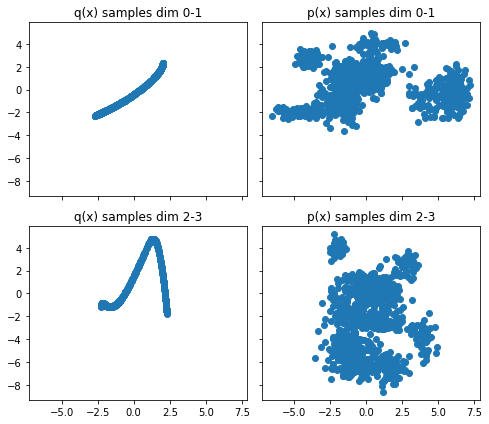

loss: 57.65616092413065, mean log p_x -15.500533323875523:  61%|██████    | 6101/10000 [26:48<15:42,  4.14it/s] 

Couldn't calculate alpha divergence over p


loss: 69.07887888058842, mean log p_x -16.09542068290242:  62%|██████▏   | 6201/10000 [27:05<15:03,  4.20it/s] 

Couldn't calculate alpha divergence over p


loss: 60.17206280137188, mean log p_x -16.264170803139464:  63%|██████▎   | 6301/10000 [27:22<16:25,  3.75it/s]

Couldn't calculate alpha divergence over p


loss: 60.751530393206416, mean log p_x -15.60419009560725:  64%|██████▍   | 6401/10000 [27:39<14:39,  4.09it/s]

Couldn't calculate alpha divergence over p


loss: 59.951525412234844, mean log p_x -15.096959187188515:  65%|██████▌   | 6501/10000 [27:56<13:40,  4.26it/s]

Couldn't calculate alpha divergence over p


loss: 92.32119598492766, mean log p_x -15.379498495308582:  66%|██████▌   | 6601/10000 [28:12<13:50,  4.09it/s] 

Couldn't calculate alpha divergence over p


loss: 62.23623555752629, mean log p_x -15.93210290113359:  67%|██████▋   | 6701/10000 [28:29<13:17,  4.13it/s] 

Couldn't calculate alpha divergence over p


loss: 60.15823199006547, mean log p_x -15.09013382270278:  68%|██████▊   | 6801/10000 [28:45<13:28,  3.96it/s]

Couldn't calculate alpha divergence over p


loss: 62.05600903840017, mean log p_x -15.347765870888555:  69%|██████▉   | 6901/10000 [29:02<12:28,  4.14it/s]

Couldn't calculate alpha divergence over p


loss: 60.75323156717114, mean log p_x -14.847160802295615:  70%|███████   | 7000/10000 [29:19<09:08,  5.47it/s]

Couldn't calculate alpha divergence over p


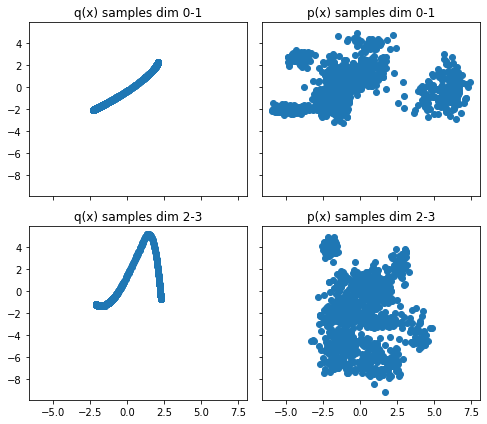

loss: 61.858290990659675, mean log p_x -14.487541410263919:  71%|███████   | 7101/10000 [29:37<12:06,  3.99it/s]

Couldn't calculate alpha divergence over p


loss: 63.03292975079296, mean log p_x -15.680945804815831:  72%|███████▏  | 7201/10000 [29:53<12:46,  3.65it/s] 

Couldn't calculate alpha divergence over p


loss: 61.06947630316259, mean log p_x -14.29759874712886:  73%|███████▎  | 7301/10000 [30:09<10:56,  4.11it/s] 

Couldn't calculate alpha divergence over p


loss: 60.95221948805892, mean log p_x -14.214042512869828:  74%|███████▍  | 7401/10000 [30:26<10:26,  4.15it/s]

Couldn't calculate alpha divergence over p


loss: 59.98282335454319, mean log p_x -13.162665711397038:  75%|███████▌  | 7501/10000 [30:42<10:19,  4.03it/s]

Couldn't calculate alpha divergence over p


loss: 63.8338118772544, mean log p_x -13.274520395735278:  76%|███████▌  | 7601/10000 [30:58<09:24,  4.25it/s] 

Couldn't calculate alpha divergence over p


loss: 64.96546740544737, mean log p_x -13.82421611935247:  77%|███████▋  | 7701/10000 [31:15<09:16,  4.13it/s]

Couldn't calculate alpha divergence over p


loss: 60.15558023117094, mean log p_x -13.274055831266322:  78%|███████▊  | 7801/10000 [31:31<08:45,  4.18it/s]

Couldn't calculate alpha divergence over p


loss: 62.812232796814264, mean log p_x -14.166584161547027:  79%|███████▉  | 7901/10000 [31:47<08:45,  4.00it/s]

Couldn't calculate alpha divergence over p


loss: 60.2160789021707, mean log p_x -12.982004863142219:  80%|████████  | 8000/10000 [32:04<05:54,  5.65it/s]  

Couldn't calculate alpha divergence over p


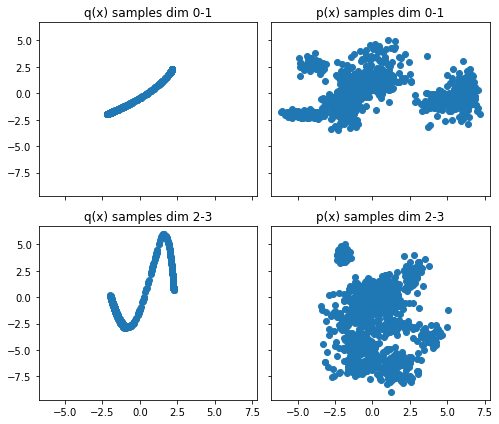

loss: 60.13000391142405, mean log p_x -13.041253571430117:  81%|████████  | 8101/10000 [32:22<08:07,  3.89it/s]

Couldn't calculate alpha divergence over p


loss: 59.5320170255448, mean log p_x -12.643031222721008:  82%|████████▏ | 8201/10000 [32:38<07:24,  4.04it/s] 

Couldn't calculate alpha divergence over p


loss: 60.13477273010234, mean log p_x -12.389246477855025:  83%|████████▎ | 8301/10000 [32:54<06:54,  4.10it/s]

Couldn't calculate alpha divergence over p


loss: 59.687834717173175, mean log p_x -12.529555392047067:  84%|████████▍ | 8401/10000 [33:10<06:22,  4.19it/s]

Couldn't calculate alpha divergence over p


loss: 59.97797274126201, mean log p_x -12.827081817175786:  85%|████████▌ | 8501/10000 [33:27<06:05,  4.10it/s] 

Couldn't calculate alpha divergence over p


loss: 59.247049608227506, mean log p_x -12.466977539034527:  86%|████████▌ | 8601/10000 [33:43<05:31,  4.23it/s]

Couldn't calculate alpha divergence over p


loss: 60.27219932323838, mean log p_x -13.441103381533681:  87%|████████▋ | 8701/10000 [33:59<05:20,  4.05it/s] 

Couldn't calculate alpha divergence over p


loss: 59.20197522391926, mean log p_x -12.862670289436496:  88%|████████▊ | 8801/10000 [34:15<04:53,  4.08it/s]

Couldn't calculate alpha divergence over p


loss: 71.62053067916405, mean log p_x -13.166854552675868:  89%|████████▉ | 8901/10000 [34:32<04:36,  3.97it/s]

Couldn't calculate alpha divergence over p


loss: 59.21554604669242, mean log p_x -12.38495250334109:  90%|█████████ | 9000/10000 [34:48<02:35,  6.45it/s] 

Couldn't calculate alpha divergence over p


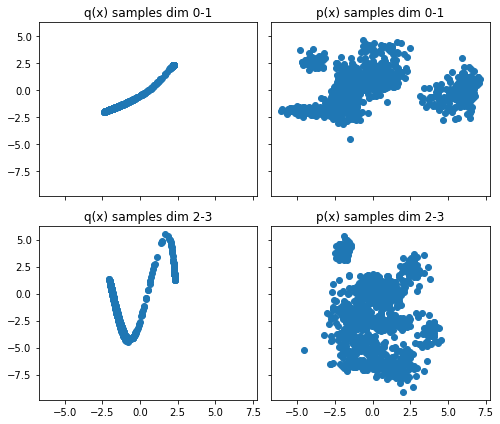

loss: 60.535389334386636, mean log p_x -12.547589144819366:  91%|█████████ | 9101/10000 [35:05<03:36,  4.15it/s]

Couldn't calculate alpha divergence over p


loss: 61.05321995783865, mean log p_x -12.778060978643174:  92%|█████████▏| 9201/10000 [35:22<03:24,  3.92it/s] 

Couldn't calculate alpha divergence over p


loss: 61.410772404257614, mean log p_x -12.440060690969931:  93%|█████████▎| 9301/10000 [35:38<02:52,  4.04it/s]

Couldn't calculate alpha divergence over p


loss: 60.29493827596226, mean log p_x -12.84006365128701:  94%|█████████▍| 9401/10000 [35:55<02:39,  3.76it/s]  

Couldn't calculate alpha divergence over p


loss: 60.435865878565316, mean log p_x -13.22545932818741:  95%|█████████▌| 9501/10000 [36:11<01:58,  4.21it/s]

Couldn't calculate alpha divergence over p


loss: 89.097806241622, mean log p_x -12.455438446422798:  96%|█████████▌| 9601/10000 [36:28<01:37,  4.11it/s]  

Couldn't calculate alpha divergence over p


loss: 59.42462295977322, mean log p_x -12.662636771645467:  97%|█████████▋| 9701/10000 [36:45<01:12,  4.10it/s]

Couldn't calculate alpha divergence over p


loss: 59.43905045681751, mean log p_x -12.929699433644906:  98%|█████████▊| 9801/10000 [37:01<00:49,  4.01it/s]

Couldn't calculate alpha divergence over p


loss: 59.37555925869798, mean log p_x -12.467863728066412:  99%|█████████▉| 9901/10000 [37:18<00:25,  3.90it/s]

Couldn't calculate alpha divergence over p


loss: 59.37555925869798, mean log p_x -12.467863728066412: 100%|██████████| 10000/10000 [37:34<00:00,  4.44it/s]


In [24]:
history_kl = tester_kl.train(epochs, batch_size=batch_size, intermediate_plots=True)

In [25]:
expectation_kl, info_kl = tester_kl.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before_kl} \n"
      f"estimate after training is {expectation_kl} \n" 
     f"effective sample size before is {info_before_kl['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info_kl['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info_kl['normalised_sampling_weights'])}")

ValueError: The value argument must be within the support

In [ ]:
expectation_kl, info_kl = tester_kl.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before_kl} \n"
      f"estimate after training is {expectation_kl} \n" 
     f"effective sample size before is {info_before_kl['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info_kl['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info_kl['normalised_sampling_weights'])}")

In [ ]:
samples_fig_after = plot_samples(tester_kl)

In [ ]:
plot_divergences(history_kl)

In [ ]:
plot_sampling_info(history_kl)

In [ ]:
hist_plot = plot_history(history_kl)